In [1]:
#pip install torch torchaudio librosa scikit-learn tqdm pandas tensorflow matplotlib seaborn

In [2]:
# In your terminal or a Colab/Jupyter notebook cell
#!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
#!git clone https://github.com/soerenab/AudioMNIST.git
#!mv free-spoken-digit-dataset/recordings recordings
#!rm -rf free-spoken-digit-dataset

# Clone the AudioMNIST dataset (This has 60 speakers)
# Note: The AudioMNIST repo often contains metadata and the audio files are zipped.
#!git clone https://github.com/soerenab/AudioMNIST.git

# 3. UNZIP the actual audio files. 
# The files are typically located in AudioMNIST/data and are zipped.
#!unzip AudioMNIST/audio/audio.zip -d recordings

# 4. Clean up the cloned repository folder
#!rm -rf AudioMNIST

# 1. Clean up old/conflicting directories
!rm -rf recordings AudioMNIST AudioMNIST-master

# 2. Clone the AudioMNIST repository
!git clone https://github.com/soerenab/AudioMNIST.git

# 3. Rename the cloned directory to the expected structure
# The GitHub user often stores the main content in a subdirectory like 'AudioMNIST-master'
!mv AudioMNIST/data recordings # The actual speaker folders (1-60) are inside AudioMNIST/audio

# 4. Clean up the cloned repository folder
!rm -rf AudioMNIST

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30137, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 30137 (delta 9), reused 4 (delta 1), pack-reused 30119 (from 1)
Receiving objects: 100% (30137/30137), 944.54 MiB | 29.44 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (30018/30018), done.


In [3]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Reshape
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns


2025-11-12 14:01:46.077076: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 14:01:46.108346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-12 14:01:46.844664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# Configuration
DATA_PATH = 'recordings'
SAMPLE_RATE = 22050
N_MFCC = 40 # Number of MFCCs to extract
MAX_PADDING_LEN = 174 # Determined empirically for this dataset, ensures all feature arrays are the same size

def extract_features(file_path, max_padding_len=MAX_PADDING_LEN):
    """Extract MFCC features from an audio file and pad/truncate to a fixed length."""
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        
        # Pad or truncate MFCCs to a fixed length (MAX_PADDING_LEN)
        if mfccs.shape[1] > max_padding_len:
            mfccs = mfccs[:, :max_padding_len]
        else:
            padding_width = max_padding_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, padding_width)), mode='constant')
            
        return mfccs

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

import os # Make sure this is imported at the top

def create_dataset(data_path):
    """
    Iterate through all speaker subdirectories (01-60), extract labels, 
    and features for the AudioMNIST structure.
    """
    all_features = []
    all_labels_digit = []
    all_labels_speaker = []
    
    # os.walk iterates through the root (recordings) and all subdirectories (01-60)
    for root, dirs, files in os.walk(data_path):
        # We only process the directories containing the actual .wav files
        # Check if we are in a speaker directory (not the top 'recordings' folder)
        if root != data_path and len(files) > 0 and files[0].endswith('.wav'): 
            
            # The speaker ID is the last part of the path (e.g., '01', '60')
            speaker = os.path.basename(root) 
            
            for filename in files:
                if filename.endswith('.wav'):
                    file_path = os.path.join(root, filename)
                    
                    # AudioMNIST filenames: [Digit]_[Index].wav (e.g., 1_0.wav)
                    parts = filename.split('_')
                    # The digit is the first part (e.g., '1' in '1_0.wav')
                    try:
                        digit = int(parts[0]) 
                    except ValueError:
                        print(f"Skipping non-digit file: {filename}")
                        continue
                    
                    features = extract_features(file_path)
                    
                    if features is not None:
                        all_features.append(features)
                        all_labels_digit.append(digit)
                        all_labels_speaker.append(speaker)

    # Convert to NumPy arrays
    X = np.array(all_features)
    y_digit = np.array(all_labels_digit)
    y_speaker = np.array(all_labels_speaker)
    
    # Critical check:
    if X.shape[0] == 0:
        print("\nFATAL ERROR: X is empty. Check your data path and file structure again.")

    return X, y_digit, y_speaker
    # Convert to NumPy arrays
    X = np.array(all_features)
    y_digit = np.array(all_labels_digit)
    y_speaker = np.array(all_labels_speaker)
    
    return X, y_digit, y_speaker

# 1. Create the dataset
X, y_digit, y_speaker = create_dataset(DATA_PATH)

# 2. Encode categorical labels (Speaker names)
speaker_encoder = LabelEncoder()
y_speaker_encoded = speaker_encoder.fit_transform(y_speaker)

# 3. Data Splitting (using the same split for both tasks)
X_train_raw, X_test_raw, y_digit_train, y_digit_test, y_speaker_train, y_speaker_test = \
    train_test_split(X, y_digit, y_speaker_encoded, test_size=0.2, random_state=42, stratify=y_digit)

# 4. Feature Scaling (Crucial for NN and SVM)
# Scale the features for each column independently across the time steps
scaler = StandardScaler()
# Reshape for scaling (features * time_steps, samples)
X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2]) 
scaler.fit(X_train_reshaped)

# Apply scaling
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train_raw.shape)
X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test_raw.shape)

# Final shapes for Deep Learning: (Samples, N_MFCC, MAX_PADDING_LEN, 1)
# The `1` is for the channel dimension, like grayscale images
X_train_dl = X_train_scaled[..., np.newaxis]
X_test_dl = X_test_scaled[..., np.newaxis]
print(f"CNN/LSTM Input Shape (Train): {X_train_dl.shape}")

# Final shapes for SVM: (Samples, Flattened Features)
X_train_svm = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_svm = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
print(f"SVM Input Shape (Train): {X_train_svm.shape}")

CNN/LSTM Input Shape (Train): (24000, 40, 174, 1)
SVM Input Shape (Train): (24000, 6960)


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to prevent TensorFlow from allocating all VRAM at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"RuntimeError: {e}")

GPU memory growth enabled.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# --- Digit Classification (10 classes: 0-9) ---
num_classes_digit = len(np.unique(y_digit))
y_digit_train_cat = to_categorical(y_digit_train, num_classes=num_classes_digit)
y_digit_test_cat = to_categorical(y_digit_test, num_classes=num_classes_digit)

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = X_train_dl.shape[1:]

# CNN for Digit Classification
cnn_digit = create_cnn_model(input_shape, num_classes_digit)
print("\n--- CNN for Digit Classification ---")
history_cnn_digit = cnn_digit.fit(
    X_train_dl, y_digit_train_cat, 
    validation_data=(X_test_dl, y_digit_test_cat), 
    epochs=10, batch_size=8, verbose=0
)
_, acc_cnn_digit = cnn_digit.evaluate(X_test_dl, y_digit_test_cat, verbose=0)
print(f"CNN (Digit) Test Accuracy: {acc_cnn_digit:.4f}")

# --- Speaker Classification (Num Speakers classes) ---
num_classes_speaker = len(speaker_encoder.classes_)
y_speaker_train_cat = to_categorical(y_speaker_train, num_classes=num_classes_speaker)
y_speaker_test_cat = to_categorical(y_speaker_test, num_classes=num_classes_speaker)

# CNN for Speaker Classification
cnn_speaker = create_cnn_model(input_shape, num_classes_speaker)
print("\n--- CNN for Speaker Classification ---")
history_cnn_speaker = cnn_speaker.fit(
    X_train_dl, y_speaker_train_cat, 
    validation_data=(X_test_dl, y_speaker_test_cat), 
    epochs=10, batch_size=32, verbose=0
)
_, acc_cnn_speaker = cnn_speaker.evaluate(X_test_dl, y_speaker_test_cat, verbose=0)
print(f"CNN (Speaker) Test Accuracy: {acc_cnn_speaker:.4f}")

/export/home/4chopra/uhh_project_dsai/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762952585.046907  504564 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3802 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6



--- CNN for Digit Classification ---


2025-11-12 14:03:06.474942: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f6fc400a050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-12 14:03:06.474955: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-11-12 14:03:06.493685: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-12 14:03:06.592989: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1762952588.477902  504721 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-12 14:04:15.275935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_131', 2

CNN (Digit) Test Accuracy: 0.9972

--- CNN for Speaker Classification ---


2025-11-12 14:04:17.639890: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 14:04:17.639912: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 14:04:18.507499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1531', 68 bytes spill stores, 68 bytes spill loads

2025-11-12 14:04:18.780452: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

CNN (Speaker) Test Accuracy: 0.9733


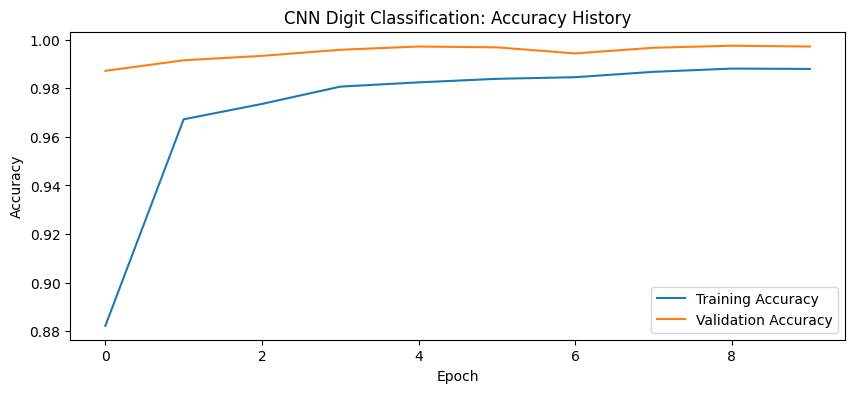

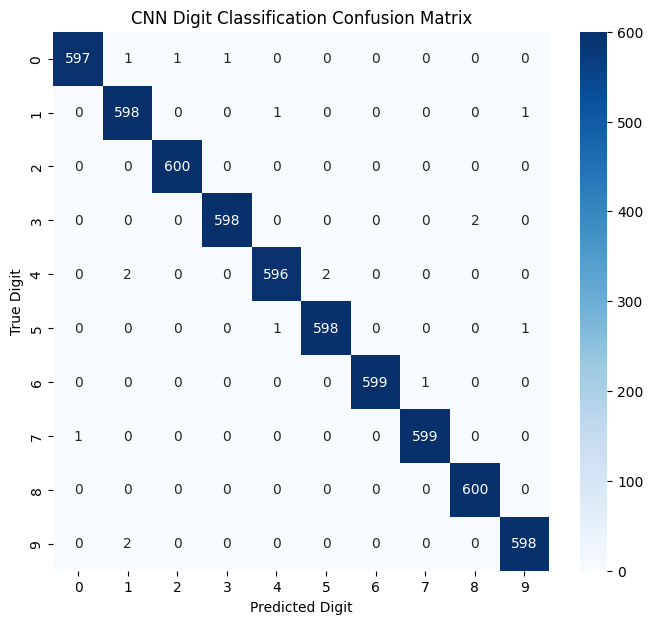

In [7]:

# --- CNN Training History Plot (Digit Classification) ---
plt.figure(figsize=(10, 4))
plt.plot(history_cnn_digit.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_digit.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Digit Classification: Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- CNN Digit Confusion Matrix ---
y_pred_cnn_digit_prob = cnn_digit.predict(X_test_dl, verbose=0)
y_pred_cnn_digit = np.argmax(y_pred_cnn_digit_prob, axis=1)

cm_cnn_digit = confusion_matrix(y_digit_test, y_pred_cnn_digit)
plt.figure(figsize=(8, 7))
sns.heatmap(cm_cnn_digit, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_digit), yticklabels=np.unique(y_digit))
plt.title('CNN Digit Classification Confusion Matrix')
plt.ylabel('True Digit')
plt.xlabel('Predicted Digit')
plt.show()

In [8]:


# Reshape input for LSTM: (Samples, Time Steps, Features)
# Current shape: (Samples, N_MFCC, MAX_PADDING_LEN, 1) -> (Samples, MAX_PADDING_LEN, N_MFCC)
X_train_lstm = X_train_dl.squeeze().transpose(0, 2, 1) 
X_test_lstm = X_test_dl.squeeze().transpose(0, 2, 1)

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, input_shape=input_shape),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_input_shape = X_train_lstm.shape[1:]

# LSTM for Digit Classification
lstm_digit = create_lstm_model(lstm_input_shape, num_classes_digit)
print("\n--- LSTM for Digit Classification ---")
history_lstm_digit = lstm_digit.fit(
    X_train_lstm, y_digit_train_cat, 
    validation_data=(X_test_lstm, y_digit_test_cat), 
    epochs=10, batch_size=32, verbose=0
)
_, acc_lstm_digit = lstm_digit.evaluate(X_test_lstm, y_digit_test_cat, verbose=0)
print(f"LSTM (Digit) Test Accuracy: {acc_lstm_digit:.4f}")

# LSTM for Speaker Classification
lstm_speaker = create_lstm_model(lstm_input_shape, num_classes_speaker)
print("\n--- LSTM for Speaker Classification ---")
history_lstm_speaker = lstm_speaker.fit(
    X_train_lstm, y_speaker_train_cat, 
    validation_data=(X_test_lstm, y_speaker_test_cat), 
    epochs=10, batch_size=32, verbose=0
)
_, acc_lstm_speaker = lstm_speaker.evaluate(X_test_lstm, y_speaker_test_cat, verbose=0)
print(f"LSTM (Speaker) Test Accuracy: {acc_lstm_speaker:.4f}")

/export/home/4chopra/uhh_project_dsai/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- LSTM for Digit Classification ---
LSTM (Digit) Test Accuracy: 0.1000

--- LSTM for Speaker Classification ---
LSTM (Speaker) Test Accuracy: 0.0125


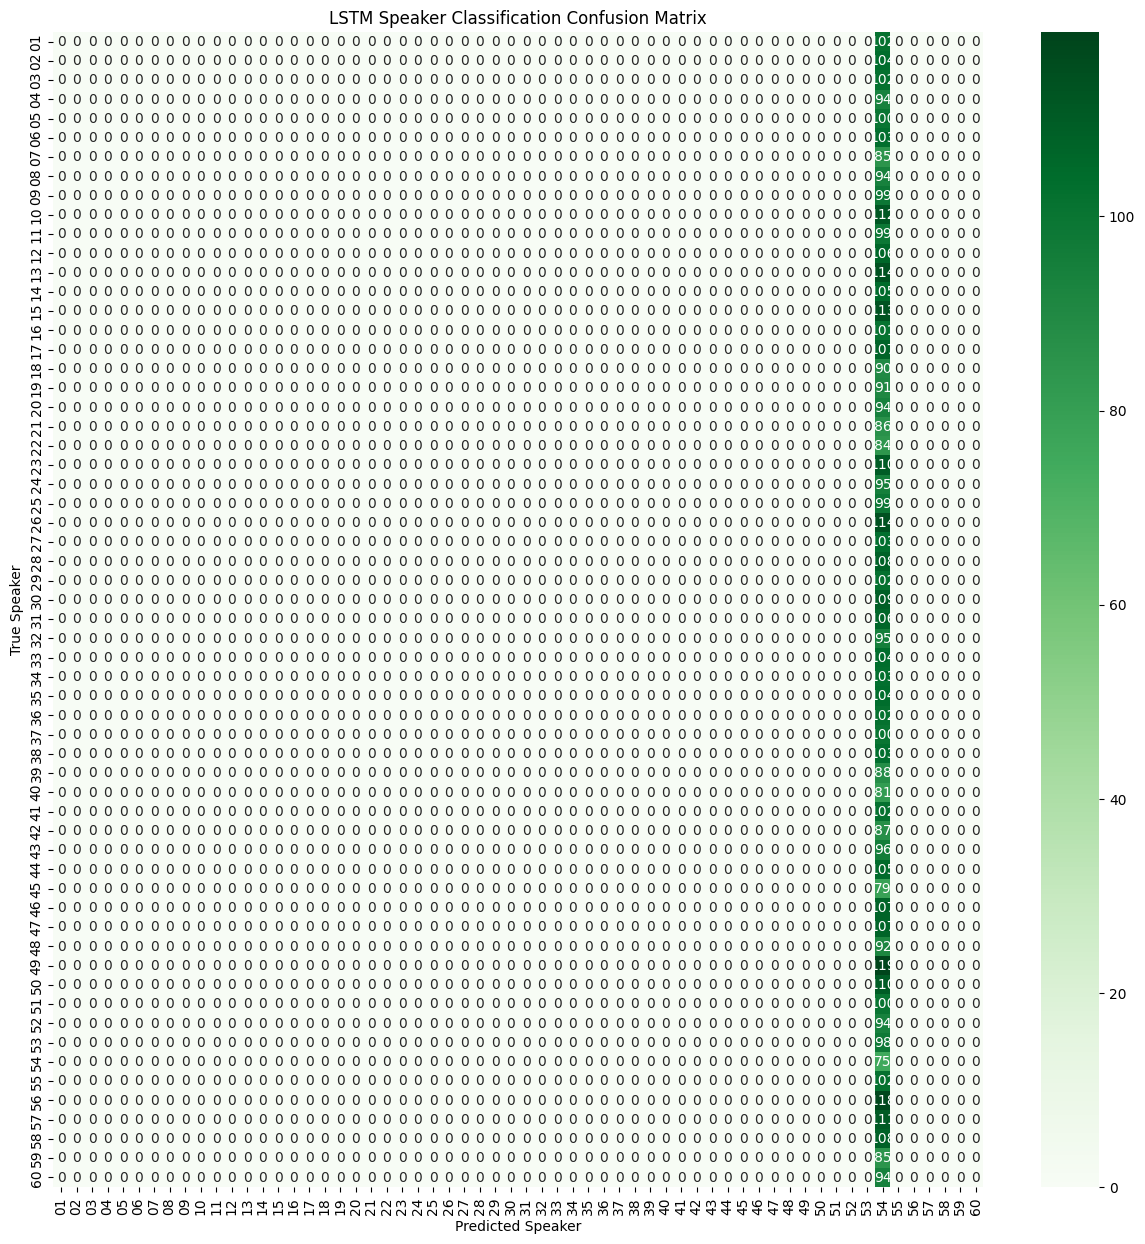

In [9]:
# --- LSTM Speaker Confusion Matrix ---
y_pred_lstm_speaker_prob = lstm_speaker.predict(X_test_lstm, verbose=0)
y_pred_lstm_speaker = np.argmax(y_pred_lstm_speaker_prob, axis=1)

cm_lstm_speaker = confusion_matrix(y_speaker_test, y_pred_lstm_speaker)
plt.figure(figsize=(15, 15))
# Use actual speaker names for labels
speaker_names = speaker_encoder.classes_
sns.heatmap(cm_lstm_speaker, annot=True, fmt='d', cmap='Greens', 
            xticklabels=speaker_names, yticklabels=speaker_names)
plt.title('LSTM Speaker Classification Confusion Matrix')
plt.ylabel('True Speaker')
plt.xlabel('Predicted Speaker')
plt.show()

In [10]:
# --- Digit Classification ---
print("\n--- SVM for Digit Classification ---")
# SVMs can be slow on large datasets, so we use a linear kernel for speed.
svm_digit = SVC(kernel='linear', C=1, random_state=42)
svm_digit.fit(X_train_svm, y_digit_train)
y_pred_svm_digit = svm_digit.predict(X_test_svm)
acc_svm_digit = accuracy_score(y_digit_test, y_pred_svm_digit)
print(f"SVM (Digit) Test Accuracy: {acc_svm_digit:.4f}")

# --- Speaker Classification ---
print("\n--- SVM for Speaker Classification ---")
svm_speaker = SVC(kernel='linear', C=1, random_state=42)
svm_speaker.fit(X_train_svm, y_speaker_train)
y_pred_svm_speaker = svm_speaker.predict(X_test_svm)
acc_svm_speaker = accuracy_score(y_speaker_test, y_pred_svm_speaker)
print(f"SVM (Speaker) Test Accuracy: {acc_svm_speaker:.4f}")


--- SVM for Digit Classification ---
SVM (Digit) Test Accuracy: 0.9938

--- SVM for Speaker Classification ---
SVM (Speaker) Test Accuracy: 0.9815


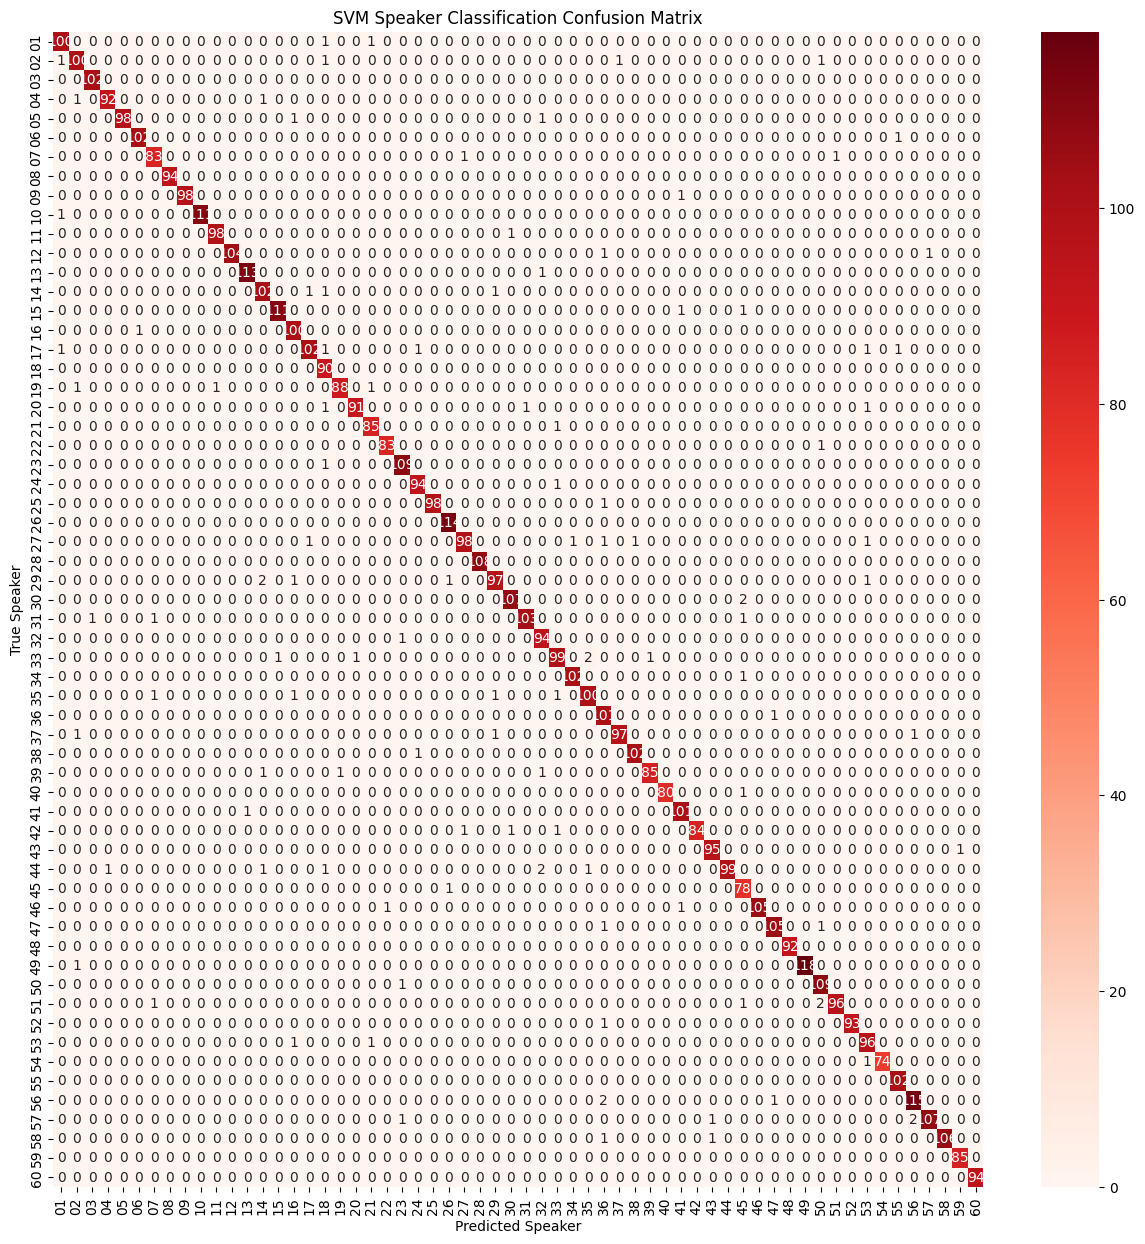

In [11]:
# --- SVM Speaker Confusion Matrix ---
# y_pred_svm_speaker is already calculated in the SVM code block
cm_svm_speaker = confusion_matrix(y_speaker_test, y_pred_svm_speaker)
plt.figure(figsize=(15, 15))
# Use actual speaker names for labels
speaker_names = speaker_encoder.classes_
sns.heatmap(cm_svm_speaker, annot=True, fmt='d', cmap='Reds', 
            xticklabels=speaker_names, yticklabels=speaker_names)
plt.title('SVM Speaker Classification Confusion Matrix')
plt.ylabel('True Speaker')
plt.xlabel('Predicted Speaker')
plt.show()

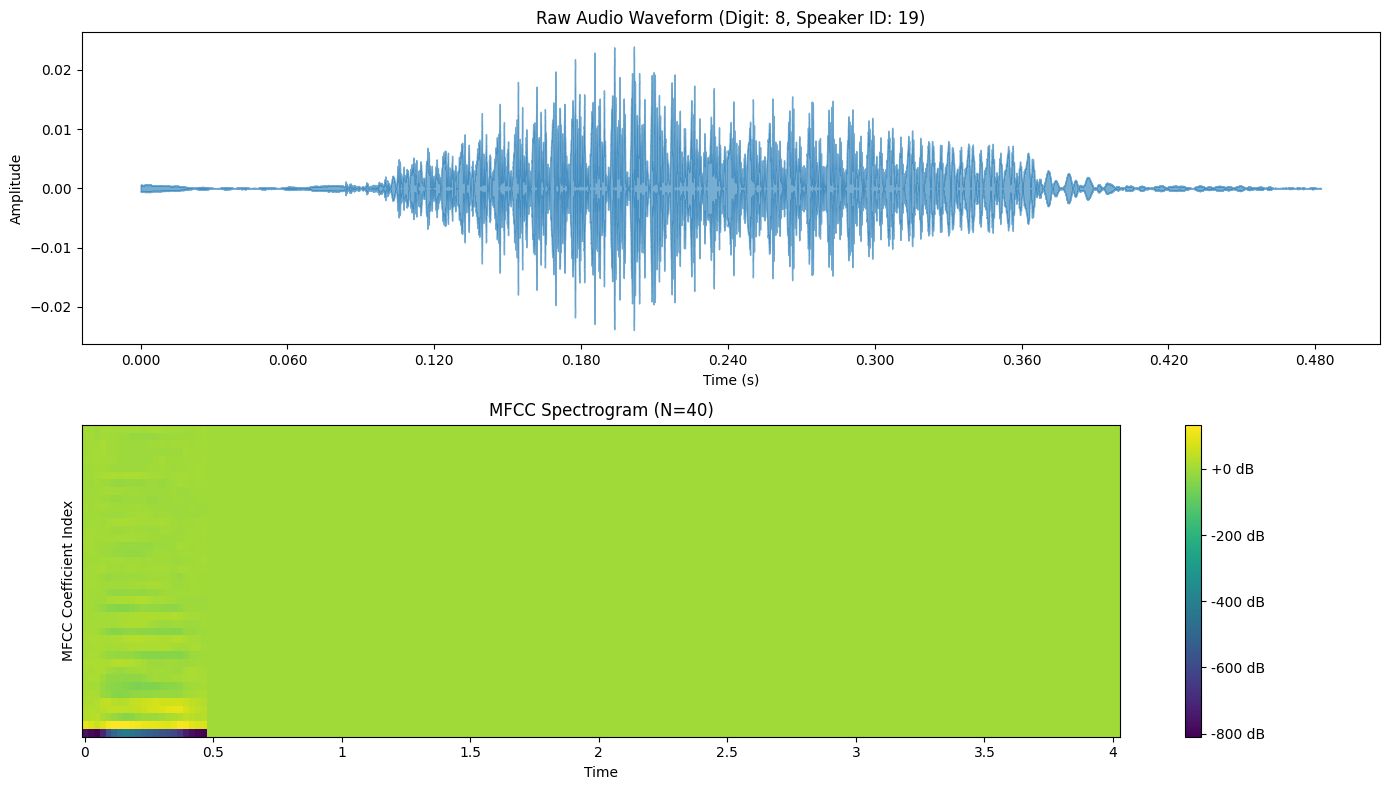

/tmp/ipykernel_504564/661810460.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=speaker_counts.index, y=speaker_counts.values, palette='coolwarm')


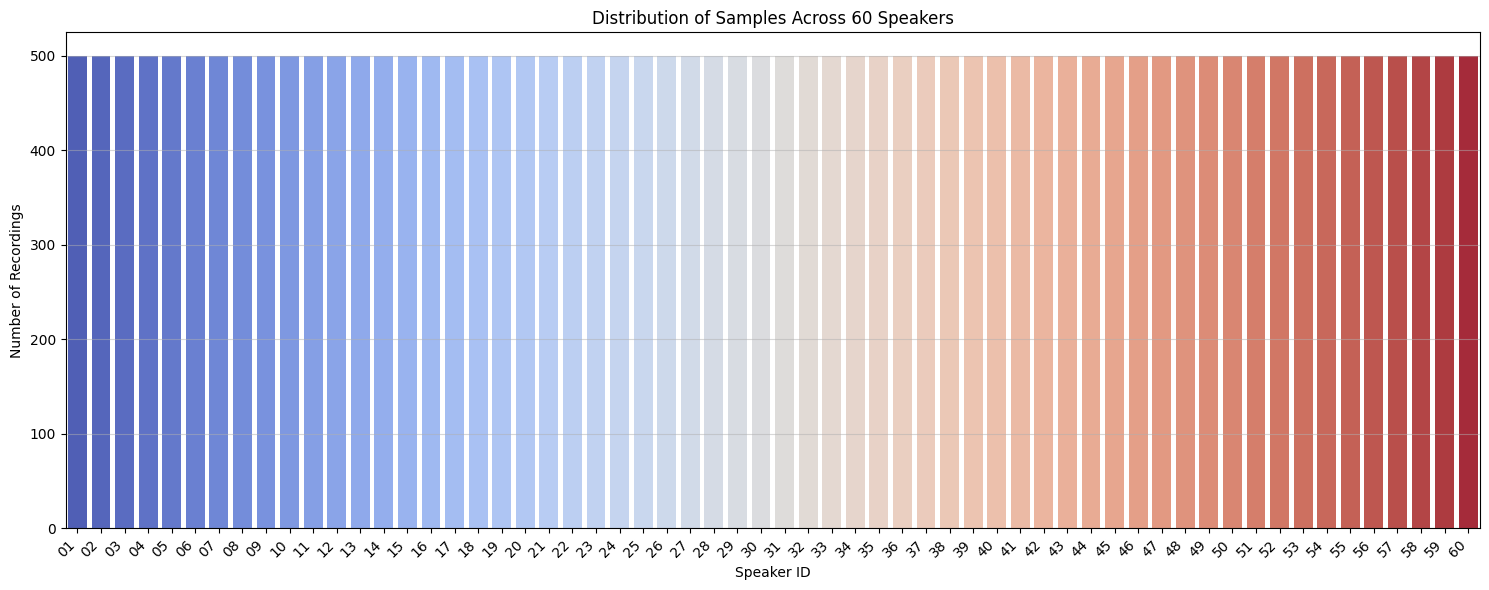

In [15]:
# --- Select a sample for visualization ---
# Find the first .wav file using os.walk since files are in subdirectories
sample_file = None
for root, dirs, files in os.walk(DATA_PATH):
    for filename in files:
        if filename.endswith('.wav'):
            sample_file = os.path.join(root, filename)
            break
    if sample_file:
        break

if sample_file is None:
    print("Error: Could not find any .wav file in subdirectories.")
    # Exit or handle the error gracefully if no files are found
else:
    # 1. Load Audio and Features
    audio, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
    
    # We will use the features extracted from X[0] but need to ensure
    # the labels correspond to the file we just loaded.
    mfccs_sample = X[0] # Assuming X is not empty and X[0] is a valid feature array
    
    # 2. Extract Labels from the new AudioMNIST filename and path
    # File format is typically: recordings/01/1_0.wav
    speaker_id = os.path.basename(os.path.dirname(sample_file)) # Extracts '01' from the path
    filename_base = os.path.basename(sample_file) # Extracts '1_0.wav'
    sample_digit = filename_base.split('_')[0] # Extracts '1'
    
    # 3. Visualization Plots

    plt.figure(figsize=(14, 8))

    # Plot 1: Raw Audio Waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio, sr=sr, alpha=0.6)
    plt.title(f'Raw Audio Waveform (Digit: {sample_digit}, Speaker ID: {speaker_id})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot 2: MFCC Feature Spectrogram (Pre-Scaling)
    plt.subplot(2, 1, 2)
    # Display the 40 MFCC coefficients over the time frames
    librosa.display.specshow(mfccs_sample, x_axis='time', sr=sr, hop_length=512, 
                             cmap='viridis', vmin=np.min(mfccs_sample), vmax=np.max(mfccs_sample))
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC Spectrogram (N={N_MFCC})')
    plt.ylabel('MFCC Coefficient Index')
    plt.tight_layout()
    plt.show()

# --- Speaker Distribution Chart ---
plt.figure(figsize=(15, 6)) # Reduced height for better display
speaker_counts = pd.Series(y_speaker).value_counts().sort_index()
sns.barplot(x=speaker_counts.index, y=speaker_counts.values, palette='coolwarm')
plt.title('Distribution of Samples Across 60 Speakers')
plt.xlabel('Speaker ID')
plt.ylabel('Number of Recordings')
plt.xticks(rotation=45, ha='right') # Rotate IDs for readability
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()